In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-02-01 13:17:26.939877: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 13:17:27.682990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-01 13:17:27.683150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-01 13:17:27.683164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load 2 plane data
data_path = '/home/hpinkard_waller/data/DINO_debugging/'
background = 100
photons_per_pixel = 1000
# patch_size = 78
# gaussian_sigma = 15 
# sample = '2_plane_lung'


single_lens_data = np.load(data_path + 'full_volume_single_lens.npy')
other_single_lens_data = np.load(data_path + 'weird_dino_single_lens_measurements.npy')
double_lens_data = np.load(data_path + 'full_volume_double_lens.npy')
many_lens_data = np.load(data_path + 'full_volume_many_lens.npy')
learned_lens_data = np.load(data_path + 'full_volume_learned_lens.npy')

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
other_single_lens_data = other_single_lens_data / other_single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel
learned_lens_data = learned_lens_data / learned_lens_data.mean() * photons_per_pixel

single_lens_data += background
other_single_lens_data += background
double_lens_data += background
many_lens_data += background
learned_lens_data += background

data_min = min(single_lens_data.min(), other_single_lens_data.min(), double_lens_data.min(), many_lens_data.min(), learned_lens_data.min())
data_max = max(single_lens_data.max(), other_single_lens_data.max(), double_lens_data.max(), many_lens_data.max(), learned_lens_data.max())

In [3]:
# print the mean photon counts for each
print(f"Single lens mean: {single_lens_data.mean()}")
print(f"Other single lens mean: {other_single_lens_data.mean()}")
print(f"Double lens mean: {double_lens_data.mean()}")
print(f"Many lens mean: {many_lens_data.mean()}")
print(f"Learned lens mean: {learned_lens_data.mean()}")

Single lens mean: 1100.0
Other single lens mean: 1100.0
Double lens mean: 1100.0
Many lens mean: 1100.0
Learned lens mean: 1100.0


In [7]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging/'
background = 50
photons_per_pixel = 400
patch_size = 78
# gaussian_sigma = 15 
sample = 'full_volume_end_to_end'

learned_lens_data = np.load(data_path + 'full_volume_learned_lens.npy')
single_lens_data = np.load(data_path + 'full_volume_single_lens.npy')
double_lens_data = np.load(data_path + 'full_volume_double_lens.npy')
many_lens_data = np.load(data_path + 'full_volume_many_lens.npy')



single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel
learned_lens_data = learned_lens_data / learned_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background
learned_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min(), learned_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max(), learned_lens_data.max())

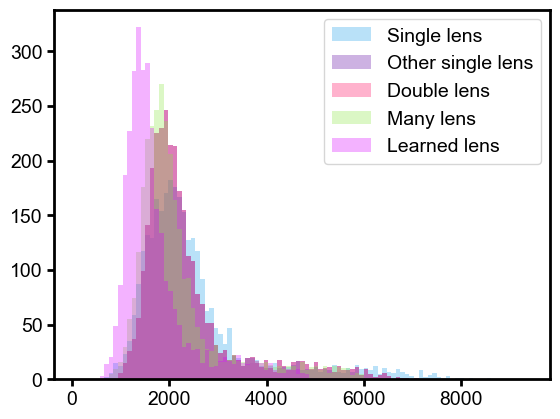

In [30]:
# plot histograms of data
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99), np.percentile(double_lens_data, 99), np.percentile(many_lens_data, 99), np.percentile(other_single_lens_data, 99))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:, 100, 100].ravel(), bins=bins, label='Single lens', alpha=0.3, log=False)
_ = ax.hist(other_single_lens_data[:, 100, 100].ravel(), bins=bins, label='Other single lens', alpha=0.3, log=False)
_ = ax.hist(double_lens_data[:, 100, 100].ravel(), bins=bins, label='Double lens', alpha=0.3, log=False)
_ = ax.hist(many_lens_data[:, 100, 100].ravel(), bins=bins, label='Many lens', alpha=0.3, log=False)
_ = ax.hist(learned_lens_data[:, 100, 100].ravel(), bins=bins, label='Learned lens', alpha=0.3, log=False)
ax.legend()

In [4]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], min(num_patches, blocks.shape[0]), replace=False)
    return blocks[indices]

def extract_uniform_patches_with_padding(data, patch_size, num_patches, verbose=False):
    # pad the edges with patch_size pixels with the minimum value 
    pad_width = ((0, 0), (patch_size, patch_size), (patch_size, patch_size))
    padded_data = np.pad(data, pad_width, mode='constant', constant_values=data.min())

    # generate random center locations within the data
    image_indices = onp.random.choice(data.shape[0], num_patches, replace=True)
    random_yx_locations = onp.random.randint(patch_size, data.shape[1] + patch_size, (num_patches, 2))

    patches = []
    for i, (image_index, (y, x)) in enumerate(zip(image_indices, random_yx_locations)):
        patch = padded_data[image_index, y-patch_size // 2:y+patch_size // 2, x-patch_size // 2:x+patch_size // 2]
        patches.append(patch)

    return np.array(patches)
    

# num_patches = 5000

# single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
# double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
# many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
# learned_lens_patches = extract_uniform_patches(learned_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

# single_lens_patches = extract_uniform_patches_with_padding(single_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)
# double_lens_patches = extract_uniform_patches_with_padding(double_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)
# many_lens_patches = extract_uniform_patches_with_padding(many_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)
# learned_lens_patches = extract_uniform_patches_with_padding(learned_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)


# single_lens_patches = single_lens_data[:, ::3, ::3]
# double_lens_patches = double_lens_data[:, ::3, ::3]
# many_lens_patches = many_lens_data[:, ::3, ::3]
# learned_lens_patches = learned_lens_data[:, ::3, ::3]


num_patches = 512
num_masked_pixels = 256

mask = onp.random.choice(onp.prod(single_lens_data.shape[1:]), num_masked_pixels, replace=False)

single_lens_patches = single_lens_data.reshape(single_lens_data.shape[0], -1)[:, mask]
other_single_lens_patches = other_single_lens_data.reshape(other_single_lens_data.shape[0], -1)[:, mask]
double_lens_patches = double_lens_data.reshape(double_lens_data.shape[0], -1)[:, mask]
many_lens_patches = many_lens_data.reshape(many_lens_data.shape[0], -1)[:, mask]
learned_lens_patches = learned_lens_data.reshape(learned_lens_data.shape[0], -1)[:, mask]


single_lens_patches = single_lens_patches[:num_patches]
other_single_lens_patches = other_single_lens_patches[:num_patches]
double_lens_patches = double_lens_patches[:num_patches]
many_lens_patches = many_lens_patches[:num_patches]
learned_lens_patches = learned_lens_patches[:num_patches]

[[<matplotlib.axis.XTick at 0x7fe57414c160>,
 [Text(0, 0, 'Single lens'),
  Text(1, 0, 'Double lens'),
  Text(2, 0, 'Learned lens'),
  Text(3, 0, 'Many lens'),
  Text(4, 0, 'DINO')],
 Text(0, 0.5, 'Mutual information (bits)')]

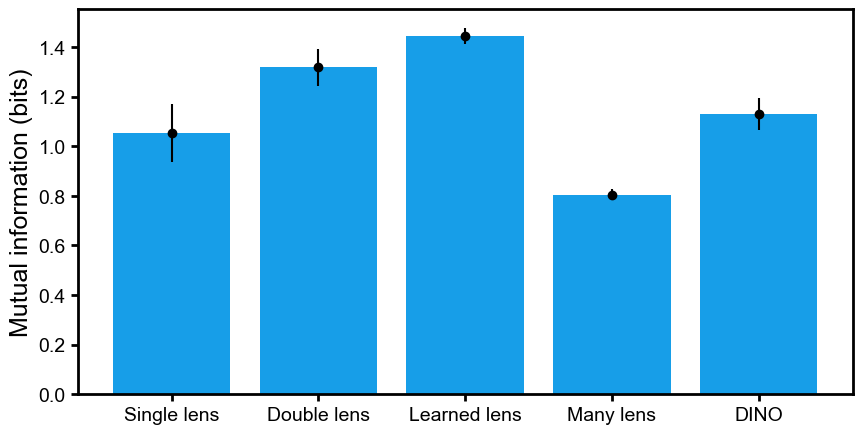

: 

In [20]:
def jax_analytic_multivariate_gaussian_entropy(cov_matrix):
    """
    Numerically stable computation of the analytic entropy of a multivariate gaussian
    """
    d = cov_matrix.shape[0]
    entropy = 0.5 * d * np.log(2 * np.pi * np.e) + 0.5 * np.sum(np.log(np.linalg.eigvalsh(cov_matrix)))
    return entropy / d
def jax_estimate_conditional_entropy(images):
    gaussian_approx = 0.5 * (np.log(2 * np.pi * np.e) + np.log(images))
    gaussian_approx = np.where(images <= 0, 0, gaussian_approx)
    per_image_entropies = np.mean(gaussian_approx, axis=1)
    h_y_given_x = np.mean(per_image_entropies)
    return h_y_given_x

def jax_estimate_mi(images):
    noisy_images = add_noise(images)
    h_y_given_x = jax_estimate_conditional_entropy(noisy_images)
    h_y = jax_analytic_multivariate_gaussian_entropy(np.cov(noisy_images, rowvar=False))
    mi = (h_y - h_y_given_x) / np.log(2)
    return mi

def jax_calculate_mi(measurements, patch_size, num_patches):
    random_indices = onp.random.choice(measurements.shape[0], num_patches, replace=False)
    batched_measurements = measurements[random_indices]

    mask = onp.random.choice(batched_measurements.shape[-2]*batched_measurements.shape[-1], patch_size, replace=False)
    measurement_patches = batched_measurements.reshape(batched_measurements.shape[0], -1)[:, mask]

    mi = jax_estimate_mi(measurement_patches)
    return mi


single_replicates = []
other_single_replicates = []
double_replicates = []
many_replicates = []
learned_replicates = []
for i in range(20):
    single_mi = jax_calculate_mi(single_lens_data, num_masked_pixels, num_patches)
    other_single_mi = jax_calculate_mi(other_single_lens_data, num_masked_pixels, num_patches)
    double_mi = jax_calculate_mi(double_lens_data, num_masked_pixels, num_patches)
    many_mi = jax_calculate_mi(many_lens_data, num_masked_pixels, num_patches)
    learned_mi = jax_calculate_mi(learned_lens_data, num_masked_pixels, num_patches)
    single_replicates.append(single_mi)
    other_single_replicates.append(other_single_mi)
    double_replicates.append(double_mi)
    many_replicates.append(many_mi)
    learned_replicates.append(learned_mi)

single_lens_median = onp.median(single_replicates)
other_single_median = onp.median(other_single_replicates)
double_median = onp.median(double_replicates)
many_median = onp.median(many_replicates)
learned_median = onp.median(learned_replicates)

single_lens_90_conf = onp.percentile(single_replicates, [5, 95])
other_single_90_conf = onp.percentile(other_single_replicates, [5, 95])
double_90_conf = onp.percentile(double_replicates, [5, 95])
many_90_conf = onp.percentile(many_replicates, [5, 95])
learned_90_conf = onp.percentile(learned_replicates, [5, 95])

# plot them on a bar chart
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot([0, 1, 2, 3, 4], [single_mi, other_single_mi, double_mi, many_mi, learned_mi], 'o')
ax.bar([0, 1, 2, 3, 4], [single_lens_median, double_median, learned_median, many_median, other_single_median])
ax.errorbar([0, 1, 2, 3, 4], [single_lens_median, double_median, learned_median, many_median, other_single_median], yerr=[single_lens_90_conf[1] - single_lens_median, double_90_conf[1] - double_median, learned_90_conf[1] - learned_median, many_90_conf[1] - many_median, other_single_90_conf[1] - other_single_median], color='k', fmt='o')
ax.set(xticks = [0, 1, 2, 3, 4], xticklabels=['Single lens', 'Double lens', 'Learned lens', 'Many lens', 'DINO'], ylabel='Mutual information (bits)')

[[<matplotlib.axis.XTick at 0x7fa10c0e39a0>,
 [Text(0, 0, 'Single lens'),
  Text(1, 0, 'Other single lens'),
  Text(2, 0, 'Double lens'),
  Text(3, 0, 'Many lens'),
  Text(4, 0, 'Learned lens')],
 Text(0, 0.5, 'Mutual information (bits)')]

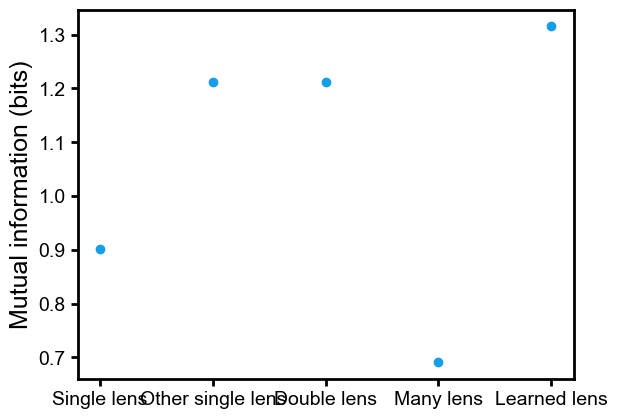

In [9]:
def analytic_multivariate_gaussian_entropy(cov_matrix):
    """
    Numerically stable computation of the analytic entropy of a multivariate gaussian
    """
    d = cov_matrix.shape[0]
    entropy = 0.5 * d * np.log(2 * np.pi * np.e) + 0.5 * np.nansum(np.log(np.linalg.eigvalsh(cov_matrix)))
    return entropy / d

def estimate_conditional_entropy(images):
    gaussian_approx = 0.5 * (np.log(2 * np.pi * np.e) + np.log(images))
    gaussian_approx = np.where(images <= 0, 0, gaussian_approx)
    per_image_entropies = np.mean(gaussian_approx, axis=1)
    h_y_given_x = np.mean(per_image_entropies)
    return h_y_given_x

def estimate_mi(images):
    noisy_images = add_noise(images)
    h_y_given_x = estimate_conditional_entropy(noisy_images)
    h_y = analytic_multivariate_gaussian_entropy(np.cov(noisy_images, rowvar=False))
    mi = (h_y - h_y_given_x) / np.log(2)
    return mi


single_mi = estimate_mi(single_lens_patches)
other_single_mi = estimate_mi(other_single_lens_patches)
double_mi = estimate_mi(double_lens_patches)
many_mi = estimate_mi(many_lens_patches)
learned_mi = estimate_mi(learned_lens_patches)

# plot them on a bar chart
fig, ax = plt.subplots()
ax.plot([0, 1, 2, 3, 4], [single_mi, other_single_mi, double_mi, many_mi, learned_mi], 'o')
ax.set(xticks = [0, 1, 2, 3, 4], xticklabels=['Single lens',  'Other single lens', 'Double lens', 'Many lens', 'Learned lens'], ylabel='Mutual information (bits)')

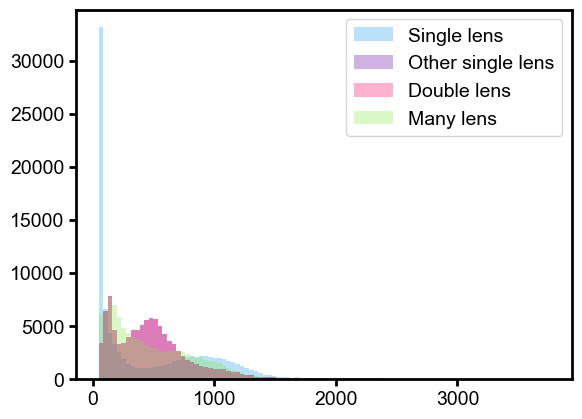

In [15]:
# plot histograms of patches
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99), np.percentile(other_single_lens_data, 99), np.percentile(double_lens_data, 99), np.percentile(many_lens_data, 99))

num_patches_to_show = 50

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_patches[:num_patches_to_show].ravel(), bins=bins, label='Single lens', alpha=0.3)
_ = ax.hist(other_single_lens_patches[:num_patches_to_show].ravel(), bins=bins, label='Other single lens', alpha=0.3)
_ = ax.hist(double_lens_patches[:num_patches_to_show].ravel(), bins=bins, label='Double lens', alpha=0.3)
_ = ax.hist(many_lens_patches[:num_patches_to_show].ravel(), bins=bins, label='Many lens', alpha=0.3)
ax.legend()

Text(-30, 80, 'Learned lens')

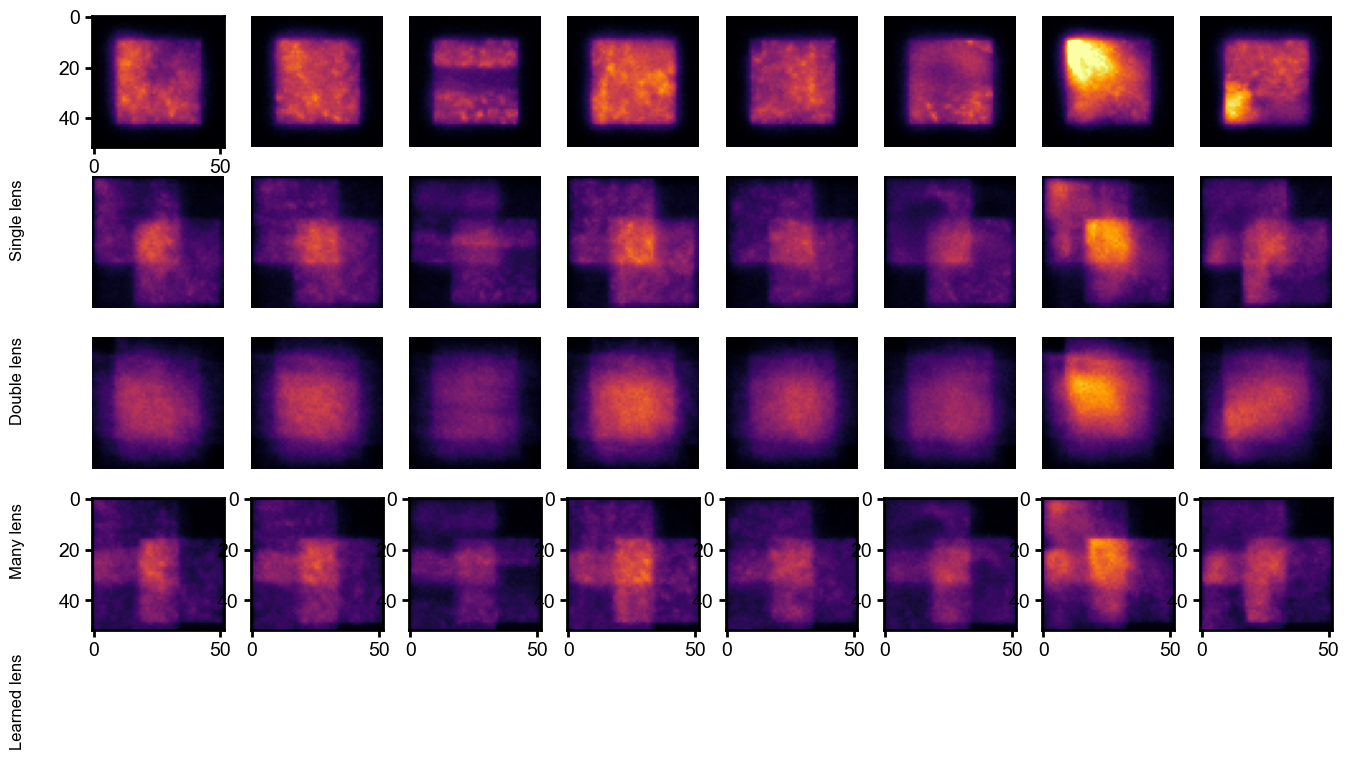

In [7]:
vmin = np.percentile(np.stack([single_lens_noisy_patches, double_lens_noisy_patches, many_lens_noisy_patches, learned_lens_noisy_patches]), 1)
vmax = np.percentile(np.stack([single_lens_noisy_patches, double_lens_noisy_patches, many_lens_noisy_patches, learned_lens_noisy_patches]), 99)

fig, axs = plt.subplots(4, 8, figsize=(16, 8))

for i in range(8):
    axs[0, i].imshow(single_lens_noisy_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_noisy_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_noisy_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[3, i].imshow(learned_lens_noisy_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

# add text identifying the images to the left of the first column
axs[0, 0].text(-30, 80, 'Single lens', fontsize=12, ha='center', va='center', rotation=90)
axs[1, 0].text(-30, 80, 'Double lens', fontsize=12, ha='center', va='center', rotation=90)
axs[2, 0].text(-30, 80, 'Many lens', fontsize=12, ha='center', va='center', rotation=90)
axs[3, 0].text(-30, 80, 'Learned lens', fontsize=12, ha='center', va='center', rotation=90)

In [9]:
@partial(jit, static_argnums=1)
def nearest_neighbors_distance(X, k):
    """
    Compute the distance to the kth nearest neighbor for each point in X by
    exhaustively searching all points in X.
    
    X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
    k : int
    """
    X = X.reshape(X.shape[0], -1)
    distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
    kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
    kth_nn = X[kth_nn_index, :]
    # kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
    kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
    return kth_nn_dist


# compute for leared noisy patches

single_lens_kth_nn = nearest_neighbors_distance(single_lens_noisy_patches, 25).mean()
learned_lens_kth_nn = nearest_neighbors_distance(learned_lens_noisy_patches, 25).mean()

print(f'Single lens kth nn: {single_lens_kth_nn}')
print(f'Learned lens kth nn: {learned_lens_kth_nn}')

Single lens kth nn: 8028.4716796875
Learned lens kth nn: 5462.91015625


In [9]:
# function to take rfft2 and concatenate real and imaginary parts
def rfft2_and_concatenate(x):
    rft2 = np.fft.rfft2(x)
    return np.stack([rft2.real, rft2.imag], axis=-1)

def rfft2_mag(x):
    rft2 = np.fft.rfft2(x)
    # take the magnitude of the real and imaginary parts
    return np.sqrt(rft2.real**2 + rft2.imag**2)

# take covariance of patches
single_lens_ft = rfft2_and_concatenate(single_lens_noisy_patches)
many_lens_ft = rfft2_and_concatenate(many_lens_noisy_patches)
learned_lens_ft = rfft2_and_concatenate(learned_lens_noisy_patches)

single_lens_ft_mag = rfft2_mag(single_lens_noisy_patches)
many_lens_ft_mag = rfft2_mag(many_lens_noisy_patches)
learned_lens_ft_mag = rfft2_mag(learned_lens_noisy_patches)

single_lens_cov = np.cov(single_lens_noisy_patches.reshape(single_lens_noisy_patches.shape[0], -1).T)
many_lens_cov = np.cov(many_lens_noisy_patches.reshape(many_lens_noisy_patches.shape[0], -1).T)
learned_lens_cov = np.cov(learned_lens_noisy_patches.reshape(learned_lens_noisy_patches.shape[0], -1).T)

# take the covariance matrix of the fts 
single_lens_cov_ft = np.cov(single_lens_ft.reshape(single_lens_ft.shape[0], -1).T)
many_lens_cov_ft = np.cov(many_lens_ft.reshape(many_lens_ft.shape[0], -1).T)
learned_lens_cov_ft = np.cov(learned_lens_ft.reshape(learned_lens_ft.shape[0], -1).T)

single_lens_cov_ft_mag = np.cov(single_lens_ft_mag.reshape(single_lens_ft_mag.shape[0], -1).T)
many_lens_cov_ft_mag = np.cov(many_lens_ft_mag.reshape(many_lens_ft_mag.shape[0], -1).T)
learned_lens_cov_ft_mag = np.cov(learned_lens_ft_mag.reshape(learned_lens_ft_mag.shape[0], -1).T)

# print the shapes of each strategy
print(f'Single lens cov shape: {single_lens_cov.shape}')
print(f'Many lens cov shape: {many_lens_cov.shape}')
print(f'Learned lens cov shape: {learned_lens_cov.shape}')

print(f'Single lens cov ft shape: {single_lens_cov_ft.shape}')
print(f'Many lens cov ft shape: {many_lens_cov_ft.shape}')
print(f'Learned lens cov ft shape: {learned_lens_cov_ft.shape}')

print(f'Single lens cov ft mag shape: {single_lens_cov_ft_mag.shape}')
print(f'Many lens cov ft mag shape: {many_lens_cov_ft_mag.shape}')
print(f'Learned lens cov ft mag shape: {learned_lens_cov_ft_mag.shape}')

Single lens cov shape: (2704, 2704)
Many lens cov shape: (2704, 2704)
Learned lens cov shape: (2704, 2704)
Single lens cov ft shape: (2808, 2808)
Many lens cov ft shape: (2808, 2808)
Learned lens cov ft shape: (2808, 2808)
Single lens cov ft mag shape: (1404, 1404)
Many lens cov ft mag shape: (1404, 1404)
Learned lens cov ft mag shape: (1404, 1404)


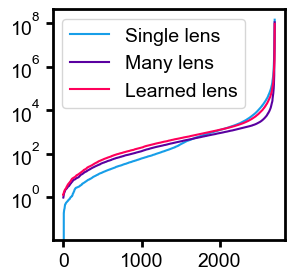

In [10]:
# plot the eignvalues of non-ft image patches
fig, ax = plt.subplots(figsize=(3, 3))
single_lens_eigvals = np.linalg.eigvalsh(single_lens_cov)
many_lens_eigvals = np.linalg.eigvalsh(many_lens_cov)
learned_lens_eigvals = np.linalg.eigvalsh(learned_lens_cov)
ax.plot(single_lens_eigvals, label='Single lens')
ax.plot(many_lens_eigvals, label='Many lens')
ax.plot(learned_lens_eigvals, label='Learned lens')
ax.set_yscale('log')
ax.legend()


In [13]:
estimate_mutual_information(single_lens_noisy_patches, verbose=True)
estimate_mutual_information(learned_lens_noisy_patches, verbose=True)

/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive

trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 1.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 10.0
Initial validation NLL: 148.63


Epoch 1:   0%|          | 0/1 [02:05<?, ?it/s]


KeyboardInterrupt: 

In [12]:
def analytic_multivariate_gaussian_entropy(cov_matrix):
    """
    Numerically stable computation of the analytic entropy of a multivariate gaussian
    """
    d = cov_matrix.shape[0]
    entropy = 0.5 * d * np.log(2 * np.pi * np.e) + 0.5 * np.nansum(np.log(np.linalg.eigvalsh(cov_matrix)))
    return entropy / d


gaussian_mi_single_lens = analytic_multivariate_gaussian_entropy(single_lens_cov) - estimate_conditional_entropy(single_lens_noisy_patches)
gaussian_mi_many_lens = analytic_multivariate_gaussian_entropy(many_lens_cov) - estimate_conditional_entropy(many_lens_noisy_patches)
gaussian_mi_learned_lens = analytic_multivariate_gaussian_entropy(learned_lens_cov) - estimate_conditional_entropy(learned_lens_noisy_patches)

# convert to bits
gaussian_mi_single_lens = gaussian_mi_single_lens / np.log(2)
gaussian_mi_many_lens = gaussian_mi_many_lens / np.log(2)
gaussian_mi_learned_lens = gaussian_mi_learned_lens / np.log(2)

print(f'Gaussian MI single lens: {gaussian_mi_single_lens}')
print(f'Gaussian MI many lens: {gaussian_mi_many_lens}')
print(f'Gaussian MI learned lens: {gaussian_mi_learned_lens}')


# # do same thign for FT

# gaussian_mi_single_lens_ft = analytic_multivariate_gaussian_entropy(single_lens_cov_ft) / 2 - estimate_conditional_entropy(single_lens_ft)
# gaussian_mi_many_lens_ft = analytic_multivariate_gaussian_entropy(many_lens_cov_ft) / 2 - estimate_conditional_entropy(many_lens_ft)
# gaussian_mi_learned_lens_ft = analytic_multivariate_gaussian_entropy(learned_lens_cov_ft) / 2 - estimate_conditional_entropy(learned_lens_ft)

# # convert to bits
# gaussian_mi_single_lens_ft = gaussian_mi_single_lens_ft / np.log(2)
# gaussian_mi_many_lens_ft = gaussian_mi_many_lens_ft / np.log(2)
# gaussian_mi_learned_lens_ft = gaussian_mi_learned_lens_ft / np.log(2)

# print(f'Gaussian MI single lens FT: {gaussian_mi_single_lens_ft}')
# print(f'Gaussian MI many lens FT: {gaussian_mi_many_lens_ft}')
# print(f'Gaussian MI learned lens FT: {gaussian_mi_learned_lens_ft}')


# # same thing for magnitude of FT
# gaussian_mi_single_lens_ft_mag = analytic_multivariate_gaussian_entropy(single_lens_cov_ft_mag) / 2 - estimate_conditional_entropy(single_lens_ft_mag)
# gaussian_mi_many_lens_ft_mag = analytic_multivariate_gaussian_entropy(many_lens_cov_ft_mag) / 2 - estimate_conditional_entropy(many_lens_ft_mag)
# gaussian_mi_learned_lens_ft_mag = analytic_multivariate_gaussian_entropy(learned_lens_cov_ft_mag) / 2 - estimate_conditional_entropy(learned_lens_ft_mag)

# # convert to bits
# gaussian_mi_single_lens_ft_mag = gaussian_mi_single_lens_ft_mag / np.log(2)
# gaussian_mi_many_lens_ft_mag = gaussian_mi_many_lens_ft_mag / np.log(2)
# gaussian_mi_learned_lens_ft_mag = gaussian_mi_learned_lens_ft_mag / np.log(2)

# print(f'Gaussian MI single lens FT mag: {gaussian_mi_single_lens_ft_mag}')
# print(f'Gaussian MI many lens FT mag: {gaussian_mi_many_lens_ft_mag}')
# print(f'Gaussian MI learned lens FT mag: {gaussian_mi_learned_lens_ft_mag}')

Gaussian MI single lens: -0.16297900676727295
Gaussian MI many lens: -0.2550557851791382
Gaussian MI learned lens: -0.011202950030565262
